Your Goal: The objective of this challenge is to forecast sticker sales in different countries. "At Kaggle, we take stickers seriously!"™️


Submissions are evaluated using the Mean Absolute Percentage Error (MAPE).

Submission File
For each id row in the test set, you must predict the target num_sold. The file should contain a header and have the following format:

id,num_sold
230130,100
230131,100
230132,100
etc.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
"""
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [2]:
#pip install holidays

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

sample_submission = pd.read_csv('sample_submission.csv')

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [5]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor


In [7]:
import holidays

In [8]:
train.head()

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [9]:
train.describe()

,id,num_sold
count,230130.000000,221259.000000
mean,115064.500000,752.527382
std,66432.953062,690.165445
min,0.000000,5.000000
25%,57532.250000,219.000000
50%,115064.500000,605.000000
75%,172596.750000,1114.000000
max,230129.000000,5939.000000


In [10]:
#train1.groupby(['num_sold']).value_counts()

In [11]:
train.isna().sum()

id             0
date           0
country        0
store          0
product        0
num_sold    8871
dtype: int64

In [12]:
train['date']

0         2010-01-01
1         2010-01-01
2         2010-01-01
3         2010-01-01
4         2010-01-01
             ...    
230125    2016-12-31
230126    2016-12-31
230127    2016-12-31
230128    2016-12-31
230129    2016-12-31
Name: date, Length: 230130, dtype: object

In [13]:
ca_holidays = holidays.country_holidays('CA') # Canada
fi_holidays = holidays.country_holidays('FI') # Finland
it_holidays = holidays.country_holidays('IT') # Italy
ke_holidays = holidays.country_holidays('KE') # Kenya
no_holidays = holidays.country_holidays('NO') # Norway
sg_holidays = holidays.country_holidays('SG') # Singapore

In [14]:
def set_holiday(row):
    VAL_HOLIDAY = 999
    if row["country"] == "Canada" and row["date"] in ca_holidays:
        row["holiday"] = VAL_HOLIDAY

    elif row["country"] == "Finland" and row["date"] in fi_holidays:
        row["holiday"] = VAL_HOLIDAY

    elif row["country"] == "Italy" and row["date"] in it_holidays:
        row["holiday"] = VAL_HOLIDAY

    elif row["country"] == "Kenya" and row["date"] in ke_holidays:
        row["holiday"] = VAL_HOLIDAY


    elif row["country"] == "Norway" and row["date"] in no_holidays:
        row["holiday"] = VAL_HOLIDAY

    elif row["country"] == "Singapore" and row["date"] in sg_holidays:
        row["holiday"] = VAL_HOLIDAY
    else:
        row['holiday'] = 0

    return row

In [15]:
train = train.apply(set_holiday, axis=1)
test = test.apply(set_holiday, axis=1)

In [16]:
train.isna().sum()

id             0
date           0
country        0
store          0
product        0
num_sold    8871
holiday        0
dtype: int64

In [17]:
train

,id,date,country,store,product,num_sold,holiday
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN,999
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,999
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,999
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,999
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,999
...,...,...,...,...,...,...,...
230125,230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0,0
230126,230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0,0
230127,230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0,0
230128,230128,2016-12-31,Singapore,Premium Sticker Mart,Kerneler,1242.0,0


In [18]:
# Import date
from datetime import date

def extract_day_month_year(dataframe, column):
    dataframe[column] = pd.to_datetime(dataframe[column])
    dataframe[column+'_day'] = dataframe[column].dt.day
    dataframe[column+'_month'] = dataframe[column].dt.month
    dataframe[column+'_year'] = dataframe[column].dt.year
    dataframe.drop(columns=[column], axis=1, inplace=True)
    

In [19]:
extract_day_month_year(train, 'date')

In [20]:
extract_day_month_year(test, 'date')

In [21]:
train.columns

Index(['id', 'country', 'store', 'product', 'num_sold', 'holiday', 'date_day',
       'date_month', 'date_year'],
      dtype='object')

In [22]:
test

,id,country,store,product,holiday,date_day,date_month,date_year
0,230130,Canada,Discount Stickers,Holographic Goose,999,1,1,2017
1,230131,Canada,Discount Stickers,Kaggle,999,1,1,2017
2,230132,Canada,Discount Stickers,Kaggle Tiers,999,1,1,2017
3,230133,Canada,Discount Stickers,Kerneler,999,1,1,2017
4,230134,Canada,Discount Stickers,Kerneler Dark Mode,999,1,1,2017
...,...,...,...,...,...,...,...,...
98545,328675,Singapore,Premium Sticker Mart,Holographic Goose,0,31,12,2019
98546,328676,Singapore,Premium Sticker Mart,Kaggle,0,31,12,2019
98547,328677,Singapore,Premium Sticker Mart,Kaggle Tiers,0,31,12,2019
98548,328678,Singapore,Premium Sticker Mart,Kerneler,0,31,12,2019


In [23]:
train.dtypes

id              int64
country        object
store          object
product        object
num_sold      float64
holiday         int64
date_day        int32
date_month      int32
date_year       int32
dtype: object

In [24]:
train['country'].value_counts()

country
Canada       38355
Finland      38355
Italy        38355
Kenya        38355
Norway       38355
Singapore    38355
Name: count, dtype: int64

In [25]:
train['product'].value_counts()

product
Holographic Goose     46026
Kaggle                46026
Kaggle Tiers          46026
Kerneler              46026
Kerneler Dark Mode    46026
Name: count, dtype: int64

In [26]:
train.count()

id            230130
country       230130
store         230130
product       230130
num_sold      221259
holiday       230130
date_day      230130
date_month    230130
date_year     230130
dtype: int64

In [27]:
# # Identificar colunas categóricas automaticamente (opcional)
# categorical_columns = df.select_dtypes(include=['object', 'category']).columns

# # Aplicar get_dummies nas colunas categóricas
# df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=False)  # drop_first=True para evitar colinearidade


In [28]:
# id              int64
# country        object
# store          object
# product        object
# num_sold      float64
# date_day        int32
# date_month      int32
# date_year       int32
# dtype: object

def convert_columns_category_onehotencoder(dataframe):
    # Identificar colunas categóricas automaticamente (opcional)
    categorical_columns = dataframe.select_dtypes(include=['object','category']).columns
    
    # Aplicar get_dummies nas colunas categóricas
    dataframe_encoded = pd.get_dummies(dataframe, columns=categorical_columns, drop_first=False)
    return dataframe_encoded
    

In [29]:
train_encoded = convert_columns_category_onehotencoder(train)

In [30]:
test_encoded = convert_columns_category_onehotencoder(test)

In [31]:
test_encoded

,id,holiday,date_day,date_month,date_year,country_Canada,country_Finland,country_Italy,country_Kenya,country_Norway,country_Singapore,store_Discount Stickers,store_Premium Sticker Mart,store_Stickers for Less,product_Holographic Goose,product_Kaggle,product_Kaggle Tiers,product_Kerneler,product_Kerneler Dark Mode
0,230130,999,1,1,2017,True,False,False,False,False,False,True,False,False,True,False,False,False,False
1,230131,999,1,1,2017,True,False,False,False,False,False,True,False,False,False,True,False,False,False
2,230132,999,1,1,2017,True,False,False,False,False,False,True,False,False,False,False,True,False,False
3,230133,999,1,1,2017,True,False,False,False,False,False,True,False,False,False,False,False,True,False
4,230134,999,1,1,2017,True,False,False,False,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98545,328675,0,31,12,2019,False,False,False,False,False,True,False,True,False,True,False,False,False,False
98546,328676,0,31,12,2019,False,False,False,False,False,True,False,True,False,False,True,False,False,False
98547,328677,0,31,12,2019,False,False,False,False,False,True,False,True,False,False,False,True,False,False
98548,328678,0,31,12,2019,False,False,False,False,False,True,False,True,False,False,False,False,True,False


In [32]:
#experiment=pd.get_dummies(train_encoded, columns=['date_month','date_year'], drop_first=False)

In [33]:
test_encoded['country_Canada']

0         True
1         True
2         True
3         True
4         True
         ...  
98545    False
98546    False
98547    False
98548    False
98549    False
Name: country_Canada, Length: 98550, dtype: bool

In [34]:
test_encoded.isna().sum()

id                            0
holiday                       0
date_day                      0
date_month                    0
date_year                     0
country_Canada                0
country_Finland               0
country_Italy                 0
country_Kenya                 0
country_Norway                0
country_Singapore             0
store_Discount Stickers       0
store_Premium Sticker Mart    0
store_Stickers for Less       0
product_Holographic Goose     0
product_Kaggle                0
product_Kaggle Tiers          0
product_Kerneler              0
product_Kerneler Dark Mode    0
dtype: int64

In [35]:
train[train['num_sold'].isna() ]

,id,country,store,product,num_sold,holiday,date_day,date_month,date_year
0,0,Canada,Discount Stickers,Holographic Goose,NaN,999,1,1,2010
45,45,Kenya,Discount Stickers,Holographic Goose,NaN,999,1,1,2010
90,90,Canada,Discount Stickers,Holographic Goose,NaN,0,2,1,2010
135,135,Kenya,Discount Stickers,Holographic Goose,NaN,0,2,1,2010
180,180,Canada,Discount Stickers,Holographic Goose,NaN,0,3,1,2010
...,...,...,...,...,...,...,...,...,...
229905,229905,Kenya,Discount Stickers,Holographic Goose,NaN,0,29,12,2016
229950,229950,Canada,Discount Stickers,Holographic Goose,NaN,0,30,12,2016
229995,229995,Kenya,Discount Stickers,Holographic Goose,NaN,0,30,12,2016
230040,230040,Canada,Discount Stickers,Holographic Goose,NaN,0,31,12,2016


In [36]:
# Aplicar o filtro corrigido
train_filtered = train_encoded.loc[
    train_encoded['num_sold'].isna() != True
]

print("Resultado:")
print(train_filtered)

Resultado:
            id  num_sold  holiday  date_day  date_month  date_year  \
1            1     973.0      999         1           1       2010   
2            2     906.0      999         1           1       2010   
3            3     423.0      999         1           1       2010   
4            4     491.0      999         1           1       2010   
5            5     300.0      999         1           1       2010   
...        ...       ...      ...       ...         ...        ...   
230125  230125     466.0        0        31          12       2016   
230126  230126    2907.0        0        31          12       2016   
230127  230127    2299.0        0        31          12       2016   
230128  230128    1242.0        0        31          12       2016   
230129  230129    1622.0        0        31          12       2016   

        country_Canada  country_Finland  country_Italy  country_Kenya  \
1                 True            False          False          False   
2 

In [37]:
train_filtered

,id,num_sold,holiday,date_day,date_month,date_year,country_Canada,country_Finland,country_Italy,country_Kenya,country_Norway,country_Singapore,store_Discount Stickers,store_Premium Sticker Mart,store_Stickers for Less,product_Holographic Goose,product_Kaggle,product_Kaggle Tiers,product_Kerneler,product_Kerneler Dark Mode
1,1,973.0,999,1,1,2010,True,False,False,False,False,False,True,False,False,False,True,False,False,False
2,2,906.0,999,1,1,2010,True,False,False,False,False,False,True,False,False,False,False,True,False,False
3,3,423.0,999,1,1,2010,True,False,False,False,False,False,True,False,False,False,False,False,True,False
4,4,491.0,999,1,1,2010,True,False,False,False,False,False,True,False,False,False,False,False,False,True
5,5,300.0,999,1,1,2010,True,False,False,False,False,False,False,False,True,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230125,230125,466.0,0,31,12,2016,False,False,False,False,False,True,False,True,False,True,False,False,False,False
230126,230126,2907.0,0,31,12,2016,False,False,False,False,False,True,False,True,False,False,True,False,False,False
230127,230127,2299.0,0,31,12,2016,False,False,False,False,False,True,False,True,False,False,False,True,False,False
230128,230128,1242.0,0,31,12,2016,False,False,False,False,False,True,False,True,False,False,False,False,True,False


<Axes: >

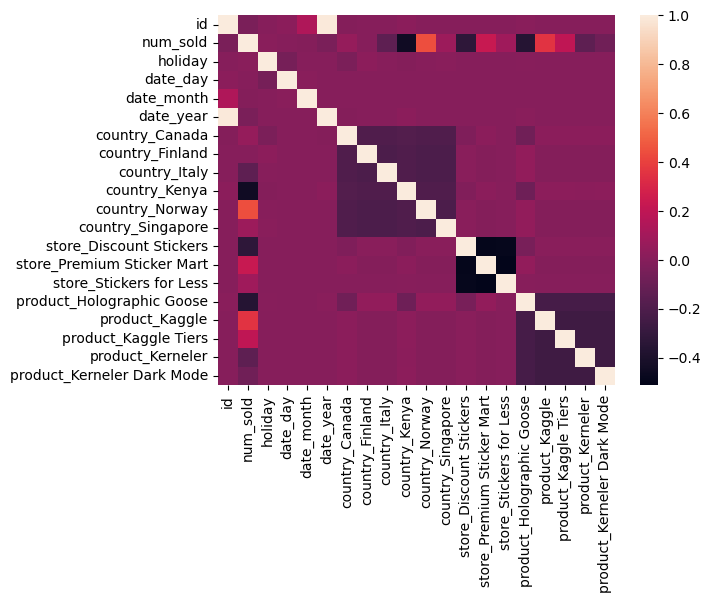

In [38]:
sns.heatmap(train_filtered.corr())

In [39]:
train_filtered.dtypes

id                              int64
num_sold                      float64
holiday                         int64
date_day                        int32
date_month                      int32
date_year                       int32
country_Canada                   bool
country_Finland                  bool
country_Italy                    bool
country_Kenya                    bool
country_Norway                   bool
country_Singapore                bool
store_Discount Stickers          bool
store_Premium Sticker Mart       bool
store_Stickers for Less          bool
product_Holographic Goose        bool
product_Kaggle                   bool
product_Kaggle Tiers             bool
product_Kerneler                 bool
product_Kerneler Dark Mode       bool
dtype: object

In [40]:
#num_columns = train_filtered.select_dtypes(include=['int64', 'float64']).columns
num_columns = train_filtered.columns

In [41]:
"""
#sns.boxplot(train_filtered['date_day'])

# Criar o grid de plots
fig, axes = plt.subplots(nrows=len(num_columns), ncols=1, figsize=(8, len(num_columns) * 4))

# Plotar cada boxplot
for i, col in enumerate(num_columns):
    sns.boxplot(data=train_filtered, x=col, ax=axes[i])
    axes[i].set_title(f'Boxplot for {col}')

plt.tight_layout()
plt.show()
"""


"\n#sns.boxplot(train_filtered['date_day'])\n\n# Criar o grid de plots\nfig, axes = plt.subplots(nrows=len(num_columns), ncols=1, figsize=(8, len(num_columns) * 4))\n\n# Plotar cada boxplot\nfor i, col in enumerate(num_columns):\n    sns.boxplot(data=train_filtered, x=col, ax=axes[i])\n    axes[i].set_title(f'Boxplot for {col}')\n\nplt.tight_layout()\nplt.show()\n"

In [42]:
#pd.set_option('display.max_rows', None)

In [43]:
#train_filtered[['date_year','date_month','num_sold']].groupby(['date_year','date_month']).sum()

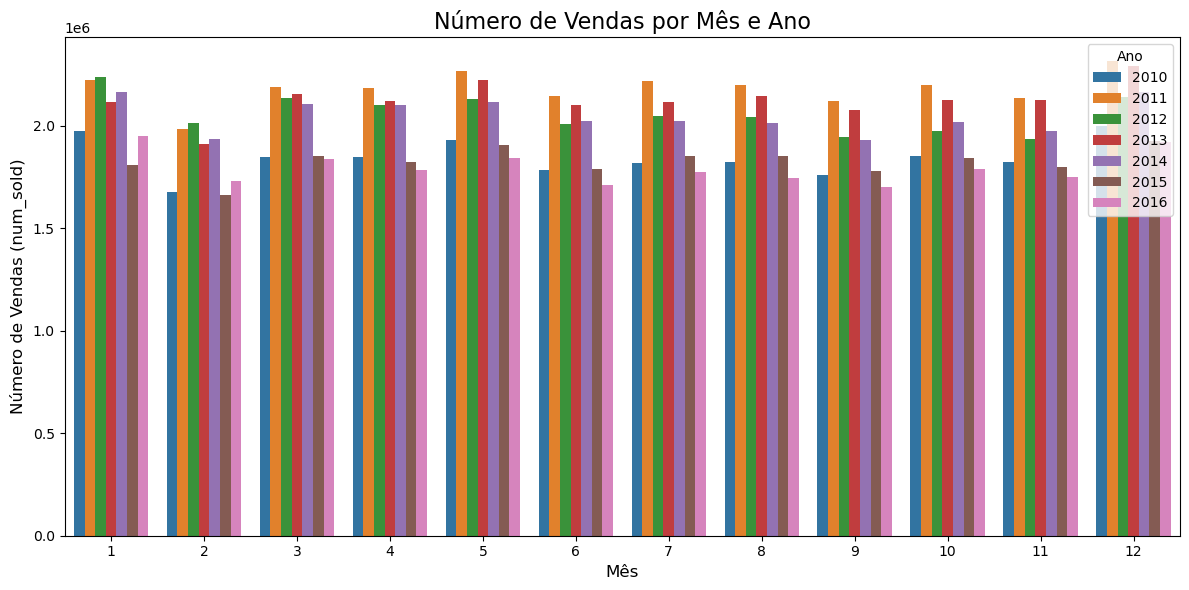

In [44]:
# Agrupar os dados
grouped_data = train_filtered[['date_year', 'date_month', 'num_sold']].groupby(['date_year', 'date_month']).sum().reset_index()

# Criar o gráfico
plt.figure(figsize=(12, 6))
sns.barplot(
    data=grouped_data, 
    x='date_month', 
    y='num_sold', 
    hue='date_year',  # Diferenciar por ano
    palette='tab10'
)

# Personalização do gráfico
plt.title("Número de Vendas por Mês e Ano", fontsize=16)
plt.xlabel("Mês", fontsize=12)
plt.ylabel("Número de Vendas (num_sold)", fontsize=12)
plt.legend(title="Ano")
plt.xticks(ticks=range(len(grouped_data['date_month'].unique())), labels=range(1, 13))

plt.tight_layout()
plt.show()

In [45]:
train_filtered['date_month']

1          1
2          1
3          1
4          1
5          1
          ..
230125    12
230126    12
230127    12
230128    12
230129    12
Name: date_month, Length: 221259, dtype: int32

In [46]:
train_filtered[ train_filtered['date_year'] == 2010 ]['num_sold']

1         973.0
2         906.0
3         423.0
4         491.0
5         300.0
          ...  
32845     329.0
32846    1889.0
32847    1668.0
32848     915.0
32849    1110.0
Name: num_sold, Length: 31141, dtype: float64

In [47]:
train_filtered[ train_filtered['date_year'] == 2010  ]['num_sold']

1         973.0
2         906.0
3         423.0
4         491.0
5         300.0
          ...  
32845     329.0
32846    1889.0
32847    1668.0
32848     915.0
32849    1110.0
Name: num_sold, Length: 31141, dtype: float64

In [48]:
train_filtered.columns

Index(['id', 'num_sold', 'holiday', 'date_day', 'date_month', 'date_year',
       'country_Canada', 'country_Finland', 'country_Italy', 'country_Kenya',
       'country_Norway', 'country_Singapore', 'store_Discount Stickers',
       'store_Premium Sticker Mart', 'store_Stickers for Less',
       'product_Holographic Goose', 'product_Kaggle', 'product_Kaggle Tiers',
       'product_Kerneler', 'product_Kerneler Dark Mode'],
      dtype='object')

In [49]:
train_filtered.isna().sum()

id                            0
num_sold                      0
holiday                       0
date_day                      0
date_month                    0
date_year                     0
country_Canada                0
country_Finland               0
country_Italy                 0
country_Kenya                 0
country_Norway                0
country_Singapore             0
store_Discount Stickers       0
store_Premium Sticker Mart    0
store_Stickers for Less       0
product_Holographic Goose     0
product_Kaggle                0
product_Kaggle Tiers          0
product_Kerneler              0
product_Kerneler Dark Mode    0
dtype: int64

In [50]:
train_filtered['holiday']

1         999
2         999
3         999
4         999
5         999
         ... 
230125      0
230126      0
230127      0
230128      0
230129      0
Name: holiday, Length: 221259, dtype: int64

In [51]:
colunms = [
'date_year',
    'date_month',
    'date_day',
'country_Norway',
'product_Kaggle',
'product_Holographic Goose',
'store_Premium Sticker Mart',
'product_Kaggle Tiers',    
    'num_sold'
]

colunms

['date_year',
 'date_month',
 'date_day',
 'country_Norway',
 'product_Kaggle',
 'product_Holographic Goose',
 'store_Premium Sticker Mart',
 'product_Kaggle Tiers',
 'num_sold']

In [52]:
#train_filtered.groupby(['date_year','country_Norway'])['num_sold'].count()

In [53]:
#train_filtered = train_filtered[colunms]

In [54]:
#continue...

Treino, predição e avaliação do modelo

In [55]:
def train_and_evaluate(models, X, y, cv=5):
    """
    Treina e avalia modelos de machine learning usando a métrica mean_absolute_percentage_error (MAPE).
    
    Args:
        models (dict): Dicionário de modelos com nomes como chave e instâncias como valores.
        X (pd.DataFrame): Conjunto de features.
        y (pd.Series or np.ndarray): Conjunto de targets.
        cv (int): Número de folds para validação cruzada (default: 5).
    
    Returns:
        pd.DataFrame: DataFrame com os resultados de validação cruzada para cada modelo.
    """
    # Criar scorer personalizado para o MAPE
    mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
    
    results = []
    for name, model in models.items():
        print(f"Treinando e avaliando o modelo: {name}")
        # Realizar validação cruzada
        scores = cross_val_score(model, X, y, cv=cv, scoring=mape_scorer)
        
        # Salvar resultados
        results.append({
            'Model': name,
            'MAPE': scores,
            'Mean MAPE': -scores.mean(),  # Negativo porque o scorer retorna valores negativos
            'Std Dev MAPE': scores.std()
        })
    
    return model, pd.DataFrame(results)


In [62]:
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import SGDRegressor
from sklearn import linear_model

In [63]:
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor 
from sklearn.neural_network import MLPRegressor

In [65]:
# Dicionário de modelos
# models = {
#     "Linear Regression": LinearRegression(),
#     "Ridge Regression": Ridge(alpha=1.0),
#     "Lasso Regression": Lasso(alpha=0.1),
#     "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
#     "Decision Tree": DecisionTreeRegressor(random_state=42)
# }




xgb_params = {
    'n_estimators': 1078, 
    'learning_rate': 0.016084079332671603, 
    'max_depth': 10, 
    'min_child_weight': 8, 
    'subsample': 0.8732132237392727, 
    'colsample_bytree': 0.9756972730817159, 
    'reg_alpha': 3.386299962300141, 
    'reg_lambda': 8.964009483088061,
    'enable_categorical': 'True',
    'device': 'cuda'
}

models = {
    "SGDRegressor":SGDRegressor(max_iter=10000, tol=1e-3, alpha=0.1, shuffle=True, loss='squared_error'),
    "Linear Regression": LinearRegression(),
    "Ridge":Ridge(alpha=1.0),
    "Lasso":Lasso(alpha=0.1),
    "Random Forest Regressor":RandomForestRegressor(n_estimators=100, n_jobs=7, random_state=42),
    "Decision Tree Regressor":DecisionTreeRegressor( random_state=42),
    "Cat  Gradient Boosting Regressor" : CatBoostRegressor(loss_function='RMSE'),
    "Gradient Boosting Regressor":GradientBoostingRegressor(n_estimators=100, random_state=42),
    "MLP Regressor":MLPRegressor(random_state=1, max_iter=500),
    "Xtreme Gradient Boosting Regressor": XGBRegressor(**xgb_params),
    "MultiTask ElasticNet":linear_model.MultiTaskElasticNet(alpha = 0.5),
    "SVR":SVR(C=1.0, epsilon=0.2)
}
    

y=train_filtered['num_sold']
X=train_filtered.loc[:, (train_filtered.columns != 'num_sold')]

model, results = train_and_evaluate(models, X, y)
print("\nResultados da Validação Cruzada:")
print(results)


Treinando e avaliando o modelo: SGDRegressor
Treinando e avaliando o modelo: Linear Regression
Treinando e avaliando o modelo: Ridge
Treinando e avaliando o modelo: Lasso
Treinando e avaliando o modelo: Random Forest Regressor
Treinando e avaliando o modelo: Decision Tree Regressor
Treinando e avaliando o modelo: Cat  Gradient Boosting Regressor
Learning rate set to 0.09276
0:	learn: 636.5185489	total: 186ms	remaining: 3m 5s
1:	learn: 585.2621118	total: 211ms	remaining: 1m 45s
2:	learn: 539.4262901	total: 235ms	remaining: 1m 18s
3:	learn: 498.5427576	total: 260ms	remaining: 1m 4s
4:	learn: 462.1823053	total: 289ms	remaining: 57.6s
5:	learn: 429.9497424	total: 314ms	remaining: 52s
6:	learn: 401.2275532	total: 342ms	remaining: 48.6s
7:	learn: 375.9413224	total: 372ms	remaining: 46.2s
8:	learn: 353.0060070	total: 399ms	remaining: 43.9s
9:	learn: 332.7856857	total: 435ms	remaining: 43.1s
10:	learn: 313.2115765	total: 458ms	remaining: 41.2s
11:	learn: 296.5753059	total: 484ms	remaining: 39.

D:\Users\makrr\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:45:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
D:\Users\makrr\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:45:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
D:\Users\makrr\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:45:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
D:\Users\makrr\anaconda3\Lib\site-packages\xgboost\core.py:158

Treinando e avaliando o modelo: MultiTask ElasticNet


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Users\makrr\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Users\makrr\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Users\makrr\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py", line 2533, in fit
    raise ValueError("For mono-task outputs, use %s" % model_str)
ValueError: For mono-task outputs, use ElasticNet


In [73]:



xgb_params = {
    'n_estimators': 1078, 
    'learning_rate': 0.016084079332671603, 
    'max_depth': 10, 
    'min_child_weight': 8, 
    'subsample': 0.8732132237392727, 
    'colsample_bytree': 0.9756972730817159, 
    'reg_alpha': 3.386299962300141, 
    'reg_lambda': 8.964009483088061,
    'enable_categorical': 'True',
    'device': 'cuda'
}

estimators = [
    ("SGDRegressor", SGDRegressor(max_iter=10000, tol=1e-3, alpha=0.1, shuffle=True, loss='squared_error')),
    ("Linear Regression", LinearRegression()),
    ("Ridge Regression", Ridge(alpha=1.0)),
    ("Lasso Regression", Lasso(alpha=0.1)),
    ('Random Forest', RandomForestRegressor(n_estimators=100, n_jobs=7, random_state=42)),
    ('Decision Tree', DecisionTreeRegressor( random_state=42)),
    ('Cat Boost Regressor', CatBoostRegressor(loss_function='RMSE')),
    ('Gradient Boosting Regressor', GradientBoostingRegressor(random_state=0)),
    ('MLP Regressor', MLPRegressor(random_state=1, max_iter=500)),
    ('Xtreme Gradient Boosting Regressor', XGBRegressor(**xgb_params)),
    ('ElasticNet', linear_model.ElasticNet(alpha = 0.5)),
    ('SVR',SVR(C=1.0, epsilon=0.2))
]

# estimators = [
#     ("Cat  Gradient Boosting Regressor", GradientBoostingRegressor(random_state=0)),
#     ("Xtreme Gradient Boosting Regressor", XGBRegressor(**xgb_params))
# ]

reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=100, n_jobs=7, random_state=42)
)

reg


StackingRegressor(estimators=[('SGDRegressor',
                               SGDRegressor(alpha=0.1, max_iter=10000)),
                              ('Linear Regression', LinearRegression()),
                              ('Ridge Regression', Ridge()),
                              ('Lasso Regression', Lasso(alpha=0.1)),
                              ('Random Forest',
                               RandomForestRegressor(n_jobs=7,
                                                     random_state=42)),
                              ('Decision Tree',
                               DecisionTreeRegressor(random_state=42)),
                              ('Cat Boost Regressor',
                               <catboost.core.Ca...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=None, min_child_weight=8,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=1078, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                              ('ElasticNet', ElasticNet(alpha=0.5)),
                              ('SVR', SVR(epsilon=0.2))],
                  final_estimator=RandomForestRegressor(n_jobs=7,
                                                        random_state=42))

In [ ]:
#print(model)

In [ ]:
# #separando dados do alvo
# X = train_filtered.drop('num_sold', axis=1)
# y = train_filtered['num_sold']

In [74]:
from sklearn.model_selection import train_test_split

In [75]:
# Divisão do conjunto de dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
reg.fit(X_train, y_train)

Learning rate set to 0.09276
0:	learn: 632.7609975	total: 27.1ms	remaining: 27s
1:	learn: 581.5604994	total: 53.1ms	remaining: 26.5s
2:	learn: 535.7538717	total: 81.3ms	remaining: 27s
3:	learn: 494.8751629	total: 107ms	remaining: 26.7s
4:	learn: 458.4976835	total: 132ms	remaining: 26.4s
5:	learn: 426.2289344	total: 159ms	remaining: 26.4s
6:	learn: 397.6818802	total: 186ms	remaining: 26.3s
7:	learn: 372.1191297	total: 228ms	remaining: 28.3s
8:	learn: 349.5235660	total: 265ms	remaining: 29.2s
9:	learn: 328.9601290	total: 294ms	remaining: 29.1s
10:	learn: 310.1248716	total: 320ms	remaining: 28.8s
11:	learn: 293.6629808	total: 345ms	remaining: 28.4s
12:	learn: 278.3434715	total: 373ms	remaining: 28.3s
13:	learn: 264.8848406	total: 400ms	remaining: 28.2s
14:	learn: 252.9969418	total: 441ms	remaining: 28.9s
15:	learn: 241.6665219	total: 473ms	remaining: 29.1s
16:	learn: 232.0270417	total: 501ms	remaining: 29s
17:	learn: 222.6246590	total: 525ms	remaining: 28.6s
18:	learn: 214.8976943	total: 

D:\Users\makrr\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:04:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
D:\Users\makrr\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:04:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


Learning rate set to 0.089547
0:	learn: 634.5087753	total: 18.7ms	remaining: 18.7s
1:	learn: 584.9220162	total: 36.9ms	remaining: 18.4s
2:	learn: 540.3734813	total: 60.2ms	remaining: 20s
3:	learn: 500.4431504	total: 84.4ms	remaining: 21s
4:	learn: 464.7452931	total: 107ms	remaining: 21.3s
5:	learn: 432.9242125	total: 131ms	remaining: 21.6s
6:	learn: 404.7460116	total: 153ms	remaining: 21.8s
7:	learn: 379.2876905	total: 178ms	remaining: 22.1s
8:	learn: 356.8109018	total: 204ms	remaining: 22.5s
9:	learn: 336.2549208	total: 223ms	remaining: 22s
10:	learn: 317.3170344	total: 241ms	remaining: 21.7s
11:	learn: 300.8602936	total: 259ms	remaining: 21.4s
12:	learn: 285.3133140	total: 277ms	remaining: 21s
13:	learn: 271.6903455	total: 294ms	remaining: 20.7s
14:	learn: 259.4337430	total: 311ms	remaining: 20.4s
15:	learn: 248.0388576	total: 328ms	remaining: 20.2s
16:	learn: 238.2514842	total: 346ms	remaining: 20s
17:	learn: 229.5575135	total: 363ms	remaining: 19.8s
18:	learn: 220.4796413	total: 37

D:\Users\makrr\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:51:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
D:\Users\makrr\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:51:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
D:\Users\makrr\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:52:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
D:\Users\makrr\anaconda3\Lib\site-packages\xgboost\core.py:158

In [ ]:
#model.fit(X_train, y_train)

In [ ]:
#y_reg_pred = reg.predict(X_test)

In [ ]:
y_pred = reg.predict(X_test)

In [ ]:
mean_absolute_percentage_error(y_test, y_pred)

In [ ]:
#y_pred = reg.predict(X_test)

In [ ]:
#mean_absolute_percentage_error(y_test, y_pred)

In [ ]:
# RandomForest = RandomForestRegressor(n_estimators=100, random_state=42)
# RandomForest.fit()
# test_encoded

submission = reg.predict(test_encoded)


In [ ]:
test_encoded

In [ ]:
id = test_encoded['id']
id

In [ ]:
## Submit notebooks to the challenge. Final


submission_final = pd.DataFrame({

        "id":id,

        "num_sold":submission

    })

submission_final.to_csv('ForecastingStickerSalesStackingRegressorV2_07012025.csv', index=False)


print(" Arquivo submission ForecastingStickerSales.csv pronto ")

In [ ]:
submission_final